In [1]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT
%matplotlib inline

In [2]:
# Constants
DATA = 'RestrictedImageNet' # Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
BATCH_SIZE = 10
NUM_WORKERS = 8
NUM_IMAGES = 2

DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA] # Class names for dataset
NUM_CLASSES = len(CLASSES) - 1 
GRAIN = 4 if DATA != 'CIFAR' else 1

In [3]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset restricted_imagenet..


In [4]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}

model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()

=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


DataParallel(
  (module): AttackerModel(
    (normalizer): InputNormalize()
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): SequentialWithArgs(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [5]:
im_test, label_test = [], []
for _, (im, label) in enumerate(test_loader):
    im_test.append(im)
    label_test.append(label)
im_test, label_test = ch.cat(im_test), ch.cat(label_test)
print(im_test.shape, label_test.shape)

torch.Size([10150, 3, 224, 224]) torch.Size([10150])


In [6]:
# Visualize seeds
perm = ch.arange(0, im_test.shape[0])
# perm = ch.randperm(im_test.shape[0])
im_shuffle = im_test[perm]
label_shuffle = label_test[perm]

img_select = im_shuffle[:NUM_IMAGES]
label_select = label_shuffle[:NUM_IMAGES]

img_select = ch.clamp(img_select, min=0, max=1)
label_str_list = [CLASSES[int(l)].split(',')[0] for l in label_select]

#show_image_row([img_select], tlist=[label_str_list], fontsize=18)

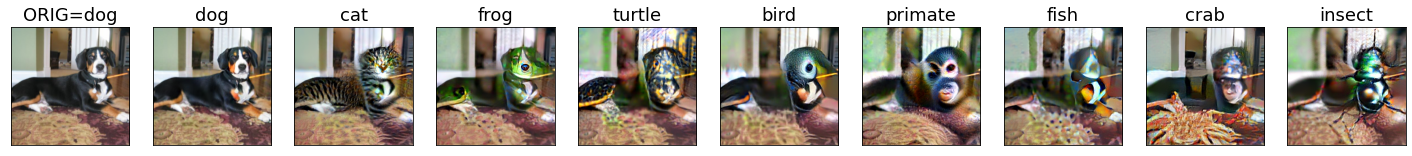

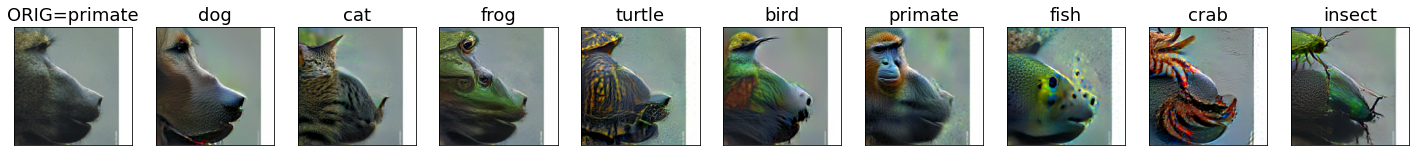

In [7]:
attack_kwargs = {
    'constraint':'2',
    'eps': 300,
    'step_size': 1,
    'iterations': 500,
    'targeted': True,
    'do_tqdm': False
}
target_indices = ch.arange(NUM_CLASSES)

for i in range(NUM_IMAGES):
    nonadv_img = img_select[i:i+1,:]
    nonadv_img_repeat = nonadv_img.repeat(NUM_CLASSES, 1, 1, 1)
    l = label_select[i]
    target_str_list = ['ORIG=' + CLASSES[int(l)].split(',')[0]] + [CLASSES[int(t)].split(',')[0] for t in target_indices]
    _, adv_img_repeat = model(nonadv_img_repeat, target_indices, make_adv=True, **attack_kwargs)
    adv_img_repeat = ch.cat([nonadv_img.cpu(), adv_img_repeat.cpu()], dim=0)
    show_image_row([adv_img_repeat.cpu()], tlist=[target_str_list], fontsize=18)
    
#print(target_indices.shape)
#adv_out, adv_img = model(img_select, target_indices[:,0], make_adv=True, **attack_kwargs)

In [10]:
print(nonadv_img_repeat.shape, adv_img_repeat.shape)
diff = (adv_img_repeat[1:,:] - nonadv_img_repeat).view(9, -1)
diff_norm = ch.norm(diff, dim=1)
print(diff_norm)

torch.Size([9, 3, 224, 224]) torch.Size([10, 3, 224, 224])
tensor([20.7332, 24.3983, 17.4684, 28.2316, 22.9788, 26.3311, 31.6803, 45.0628,
        28.0038])
